# **LAB 2: Optimizing Generative AI Workloads on ARM Server Processors**

## Introduction

Welcome to the second lab in our series on **Optimizing Generative AI Workloads with ARM Processors**! In this hands-on session, you will build on the concepts learned in Lab 1—particularly vector processing on ARM devices—by leveraging a wider range of advanced ARM intrinsics. These include:

- **NEON** (for SIMD acceleration)
- **DotProd** (dot product extension)
- **I8MM** (integer matrix multiplication)
- **SVE** (Scalable Vector Extension)

We will utilize these intrinsics through the **KleidiAI library**, which provides optimized microkernels for matrix multiplication and other core operations. You will learn how to benchmark these kernels against **BLAS**, the standard library for linear algebra routines. Beyond benchmarking, you will also integrate these optimized kernels into PyTorch to enable **quantized matrix multiplication**, and ultimately apply **4-bit quantization** on the **OpenELM-7B** model from Apple to measure latency and memory improvements.

---

### **Lab Objectives**

1. **Explore Advanced ARM Intrinsics**  
   Gain a deeper understanding of the **DotProd**, **I8MM**, and **SVE** intrinsics available in modern ARM architectures, and see how they accelerate matrix multiplications.

2. **Learn the KleidiAI Library**  
   Discover how KleidiAI implements these intrinsics in microkernels and why it can outperform traditional approaches in certain use cases.

3. **Benchmark KleidiAI Against BLAS**  
   Implement and benchmark KleidiAI microkernels—using different intrinsics—against the **BLAS** library to quantify performance benefits.

4. **Quantize Matrix Multiplication in PyTorch**  
   Integrate the KleidiAI kernels into PyTorch to perform quantized matrix multiplications, comparing performance and accuracy trade-offs.

5. **Implement and Evaluate 4-Bit Quantization**  
   Apply **groupwise int4 quantization** to the **OpenELM-7B** model, measuring **latency** and **memory** improvements on ARM server-class processors.

---
### **Prerequisites**

- **Basic Knowledge of Linux**: Comfortable working in a Linux terminal.
- **C/C++ and Python Programming**: Familiarity with writing and compiling code.
- **Matrix Multiplication**: Understanding of linear algebra basics.
- **Completion of Lab 1 (Recommended)**: Familiarity with NEON vector instructions and quantization concepts.

---
**By the end of this lab**, you will have hands-on experience combining low-level ARM intrinsics, specialized libraries, and quantization techniques to push the performance of large language models on ARM server processors. These skills will enable you to optimize generative AI workloads in both **resource-constrained** and **server-class** ARM environments.


#1. Explore Advanced ARM Intrinsics 
lets start by grabbing the largest weight matrix multiplication used in the forward pass of the OpenELM-7B model. We can do that by running the next two cells 


In [1]:
import torch 
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", trust_remote_code=True) # download the tokenizer
model = AutoModelForCausalLM.from_pretrained("apple/OpenELM-270M-Instruct", trust_remote_code=True) # download the model (this may take a while)



### Collect largest weight matmul in LLM 

In [2]:
import torch
import torch.nn.functional as F
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
activations = {} # Initialize to store the activations

prompt = "Arm is a company that"  # create a sample prompt for the llm 
inputs = tokenizer(prompt, return_tensors="pt") # tokenize the prompt ready for inputting into the model

# Define a hook function to capture output activation of each matrix multiplication
def get_activation_input(name):
    def hook(model, input, output):
        # 'input' is a tuple; we take the first element for the input tensor
        activations[name] = output[0]
    return hook


# the largest matmul is after the last normalization, We therefor apply the hook 
# on this layer to the the input for th last matmul which is the projection from 
# tokens to probabilities over the all possible tokens in the vocabulary.
layer = model.transformer.norm
hook_handle = layer.register_forward_hook(get_activation_input('token_activations'))

# Run the model forward pass
with torch.no_grad():
    model(**inputs)

# Extract the projection weight matrix and the input activation tensor from the hook
W = model.transformer.token_embeddings.weight.data.clone()
X = activations['token_activations']

hook_handle.remove()
print(f"The collected weight matrix has shape {W.shape[0]}x{W.shape[1]} (output_channels x input_channels)")
print(f"The collected activation tensor has shape {X.shape[0]}x{X.shape[1]} (sequence_length x input_channels)")

The collected weight matrix has shape 32000x1280 (output_channels x input_channels)
The collected activation tensor has shape 6x1280 (sequence_length x input_channels)


# Explanation

We have two key tensors:

1. **Activation Tensor `X`**: Shape \([6, 1280]\)  
   - This corresponds to 6 tokens in the input sequence, each represented by a 1280-dimensional embedding generated by the OpenElm transformer.

2. **Weight Matrix**: Shape \([32000, 1280]\)  
   - There are 32,000 possible tokens in the model’s vocabulary, and each token is associated with a 1280-dimensional parameter vector.

When we multiply these two tensors, their common dimension of 1280 aligns, producing an output of shape \([6, 32000]\). The first dimension corresponds to the 6 tokens in the sequence, and the second dimension corresponds to the 32,000 tokens in the vocabulary.

The resulting matrix provides the logits for every token in the vocabulary for each position in the sequence. These logits can then be used to generate probability distributions over the next predicted token.


Now that we have saved the inputs to the matrix multiplication, lets measure torch's matrix multiplication latency from python. We can use that as a benchmark to compare against when harnessing the arm intrinsics for further acceleration. 

### Benchmark torch latency for the matmul

In [3]:
import time

def measure_time():
    start = time.perf_counter()
    with torch.no_grad():
        y = torch.mm(X, W.T)
    end = time.perf_counter()
    return (end - start) * 1_000_000  # Convert to microseconds

# Run multiple times and average
times = [measure_time() for _ in range(100)]
torch_latency_us = sum(times) / len(times)
print(f"{torch_latency_us:.2f} µs")

7445.78 µs


Lets write out the matrices to disk so we can perform the matrix multiplications in c++ with the arm intinsics. 

In [4]:
!mkdir src/cpp/assets/

X.numpy().tofile("src/cpp/assets/x_fp32.bin")
W.numpy().tofile("src/cpp/assets/w_fp32.bin")

mkdir: cannot create directory ‘src/cpp/assets/’: File exists


## Naive Matmul Operator
We can again also write the naive implementation of the matrix multiplication in c++ without any parallelization or memory optimizations. This is just like in the first lab except that the matrix multiplication is involving non-square matrices, and hence we have to pass the multiplication dimensions 'M, K and N'. Note that we again store the matrices as a flat pointer, representing the matrices as a single vector in row-major order. (Go back to lab-1 to learn about row-major if you are unsure)

In [5]:
%%writefile src/cpp/naive/kernel.cpp

#include <stdio.h>
#include <stdlib.h>
#include <time.h>

void matrix_multiply_naive(float* A, float* B, float* C, int M, int K, int N) {
    // # M: the number of rows in the left hand matric (M = A.shape[0])
    // # K: the inner dimensions of the multiple (K == A.shape[1] == B.shape[0])
    // # N: the number of columns in the right hand matrix (N == B.shape[1])
    for (int i = 0; i < M; i++) {
        for (int j = 0; j < N; j++) {
            C[i * N + j] = 0;
            for (int k = 0; k < K; k++) {
                C[i * N + j] += A[i * K + k] * B[k * N + j];
            }
        }
    }
}

Overwriting src/cpp/naive/kernel.cpp


### Benchmark the Naive Operator

In [12]:
import os
import subprocess

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define the build directory path
build_dir = "src/cpp/naive/build"

# Create the build directory if it doesn't exist
os.makedirs(build_dir, exist_ok=True)

# Configure the project with CMake
subprocess.run(["cmake", ".."], cwd=build_dir, check=True)

# Build the project using Make
subprocess.run(["make"], cwd=build_dir, check=True)
print(" ")
print("======> Benchmarking Naive Kernel <========")
# Execute the benchmark binary
subprocess.run(["./benchmark_naive"], cwd=build_dir)
print("=========> Benchmark completed. <========== \n")


-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/naive/build
[100%] Built target benchmark_naive
 
======> Benchmarking Naive Kernel <========
Time taken: 1183.95 microseconds
=========> Benchmark completed. <========== 



# Clone KleidiAI

In [13]:
!git clone https://git.gitlab.arm.com/kleidi/kleidiai.git

fatal: destination path 'kleidiai' already exists and is not an empty directory.


## Understanding the KleidiAI Micro-Kernel

...

## Creating a Kleidi Kernel

...

# FP32 NEON MLA

In [14]:
%%writefile src/cpp/f32_f32_f32p/kernel.cpp

#include <arm_neon.h>

#include "kai_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla.h"
#include "kai_matmul_clamp_f32_f32_f32p_interface.h"


constexpr kai_matmul_clamp_f32_f32_f32p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_n_step_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_nr_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_kr_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_sr_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_lhs_offset_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_rhs_packed_offset_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_dst_offset_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_dst_size_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_run_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla};

Overwriting src/cpp/f32_f32_f32p/kernel.cpp


### Build and Benchmark

In [17]:
import os
import subprocess

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define the build directory path
build_dir = "src/cpp/f32_f32_f32p/build"

# Create the build directory if it doesn't exist
os.makedirs(build_dir, exist_ok=True)

# Configure the project with CMake
subprocess.run(["cmake", ".."], cwd=build_dir, check=True)

# Build the project using Make
subprocess.run(["make"], cwd=build_dir, check=True)

print(" ")
print("=====> Benchmarking KleidiAI FP32 Kernel <========")
# Execute the benchmark binary
subprocess.run(["./benchmark_f32"], cwd=build_dir)
print("===========> Benchmark completed. <=============== \n")

-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
[ 33%] Built target benchmark_f32
[ 66%] Built target benchmark_f32_scaling
[100%] Built target kai_f32_inf
 
=====> Benchmarking KleidiAI FP32 Kernel <========
Time taken: 11.619 microseconds
===========> Benchmark completed. <=============== 



Lets use a tool called process watch to check what kernels are being run?

In [35]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/blas/build/blas_f32_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 46401


In [36]:
!sudo ./processwatch/processwatch -p 46401 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              0.00     0.00     0.00     0.00     0.00     100.00   25293   
46401    blas_f32_inf     0.00     0.00     0.00     0.00     0.00     100.00   25293   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              0.00     0.00     0.00     0.00     0.00     100.00   26602   
46401    blas_f32_inf     0.00     0.00     0.00     0.00     0.00     100.00   26602   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              0.00     0.00     0.00     0.00     0.00     100.00   25277   
46401    blas_f32_inf     0.00     0.00     0.00     0.00     0.00     100.00   25277   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              0.00     0.00     0.00     0.00     0.00     100.00   26624   
46401    blas_f32

In [37]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

# FP16 NEON MLA 

In [38]:
%%writefile src/cpp/f16_f16_f16p/kernel.cpp

#include <arm_neon.h>

#include "kai_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla.h"
#include "kai_matmul_clamp_f16_f16_f16p_interface.h"

constexpr kai_matmul_clamp_f16_f16_f16p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_n_step_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_nr_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_kr_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_sr_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_lhs_offset_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_rhs_packed_offset_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_dst_offset_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_dst_size_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_run_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla};

Overwriting src/cpp/f16_f16_f16p/kernel.cpp


### Build and Benchmark

In [39]:
import os
import subprocess

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define the build directory path
build_dir = "src/cpp/f16_f16_f16p/build"

# Create the build directory if it doesn't exist
os.makedirs(build_dir, exist_ok=True)

# Configure the project with CMake
subprocess.run(["cmake", ".."], cwd=build_dir, check=True)

# Build the project using Make
subprocess.run(["make"], cwd=build_dir, check=True)

print(" ")
print("=====> Benchmarking KleidiAI FP16 Kernel <========")
# Execute the benchmark binary
subprocess.run(["./benchmark_f16"], cwd=build_dir)
print("===========> Benchmark completed. <=============== \n")


-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
[  6%] Building CXX object CMakeFiles/benchmark_f16.dir/benchmark_f16.cpp.o
[ 13%] Building CXX object CMakeFiles/benchmark_f16.dir/kernel.cpp.o
[ 20%] Linking CXX executable benchmark_f16
[ 33%] Built target benchmark_f16
[ 40%] Building CXX object CMakeFiles/benchmark_f16_scaling.dir/benchmark_f16_scaling.cpp.o
[ 46%] Building CXX object CMakeFiles/benchmark_f16_scaling.dir/kernel.cpp.o
[ 53%] Linking CXX executable benchmark_f16_scaling
[ 66%] Built target benchmark_f16_scaling
[ 73%] Building CXX object CMakeFiles/kai_f16_inf.dir/kai_f16_inf.cpp.o
[ 80%] Building CXX object CMakeFiles/kai_f16_inf.dir/kernel.cpp.o
[ 86%] Linking CXX executable kai_f16_inf
[100%] Built target kai_f16_inf
 
=====> Benchmarking KleidiAI FP16 Kernel <========
Time taken: 37.979 microseconds
===========> Benchmark completed. <=============== 



In [41]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f16_f16_f16p/build/kai_f16_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 46569


In [42]:
!sudo ./processwatch/processwatch -p 46569 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              83.82    0.00     0.00     0.00     0.00     100.00   25216   
46569    kai_f16_inf      83.82    0.00     0.00     0.00     0.00     100.00   25216   
^C


In [43]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

## DotProd

In [44]:
%%writefile src/cpp/f32_i8_i4_dotprod/kernel.cpp

#include <arm_neon.h>
#include <string>

#include "kai_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod.h"
#include "kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_interface.h"


constexpr kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_n_step_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_mr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_nr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_kr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_sr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_lhs_packed_offset_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_rhs_packed_offset_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_dst_offset_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_dst_size_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_run_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod};

Overwriting src/cpp/f32_i8_i4_dotprod/kernel.cpp


### Build and Run 

In [45]:
import os
import subprocess

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define the build directory path
build_dir = "src/cpp/f32_i8_i4_dotprod/build"

# Create the build directory if it doesn't exist
os.makedirs(build_dir, exist_ok=True)

# Configure the project with CMake
subprocess.run(["cmake", ".."], cwd=build_dir, check=True)

# Build the project using Make
subprocess.run(["make"], cwd=build_dir, check=True)

print(" ")
print("=====> Benchmarking KleidiAI Int8 DotProd Kernel <========")
# Execute the benchmark binary
subprocess.run(["./benchmark_dotprod"], cwd=build_dir)
print("===========> Benchmark completed. <=============== \n")

-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_dotprod/build
[  5%] Building CXX object CMakeFiles/benchmark_dotprod.dir/benchmark_i8_dotprod.cpp.o
[ 11%] Building CXX object CMakeFiles/benchmark_dotprod.dir/kernel.cpp.o
[ 16%] Linking CXX executable benchmark_dotprod
[ 33%] Built target benchmark_dotprod
[ 38%] Building CXX object CMakeFiles/benchmark_dotprod_scaling.dir/benchmark_i8_dotprod_scaling.cpp.o
[ 44%] Building CXX object CMakeFiles/benchmark_dotprod_scaling.dir/kernel.cpp.o
[ 50%] Linking CXX executable benchmark_dotprod_scaling
[ 66%] Built target benchmark_dotprod_scaling
[ 72%] Building CXX object CMakeFiles/kai_i8_dotprod_inf.dir/kai_i8_dotprod_inf.cpp.o
[ 77%] Building CXX object CMakeFiles/kai_i8_dotprod_inf.dir/kernel.cpp.o
[ 83%] Linking CXX executable kai_i8_dotprod_inf
[100%] Built target kai_i8_dotprod_inf
 
=====> Benchmarking KleidiAI Int8 DotProd Kernel <========
Tim

In [46]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f32_i8_i4_dotprod/build/kai_i8_dotprod_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 46766


In [47]:
!sudo ./processwatch/processwatch -p 46766 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              57.62    0.00     0.00     0.00     5.20     100.00   25283   
46766    kai_i8_dotprod_  57.62    0.00     0.00     0.00     5.20     100.00   25283   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              57.74    0.00     0.00     0.00     5.42     100.00   26606   
46766    kai_i8_dotprod_  57.74    0.00     0.00     0.00     5.42     100.00   26606   
^C


In [48]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

## I8MM

In [14]:
%%writefile src/cpp/f32_i8_i4_i8mm/kernel.cpp

#include <arm_neon.h>
#include "kai_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm.h"
#include "kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_interface.h"


constexpr kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_n_step_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_mr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_nr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_kr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_sr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_lhs_packed_offset_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_rhs_packed_offset_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_dst_offset_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_dst_size_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_run_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm};



Writing src/cpp/f32_i8_i4_i8mm/kernel.cpp


### Build and Run 

In [22]:
import os
import subprocess

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define the build directory path
build_dir = "src/cpp/f32_i8_i4_i8mm/build"

# Create the build directory if it doesn't exist
os.makedirs(build_dir, exist_ok=True)

# Configure the project with CMake
subprocess.run(["cmake", ".."], cwd=build_dir, check=True)

# Build the project using Make
subprocess.run(["make"], cwd=build_dir, check=True)

print(" ")
print("=====> Benchmarking KleidiAI Int8 I8MM Kernel <========")
# Execute the benchmark binary
subprocess.run(["./benchmark_i8_i8mm"], cwd=build_dir)
print("===========> Benchmark completed. <=============== \n")


-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_i8mm/build
[ 33%] Built target benchmark_i8_i8mm
[ 66%] Built target benchmark_i8_i8mm_scaling
[100%] Built target kai_i8_i8mm_inf
 
=====> Benchmarking KleidiAI Int8 I8MM Kernel <========
Time taken: 7.992 microseconds
===========> Benchmark completed. <=============== 



In [49]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f32_i8_i4_i8mm/build/kai_i8_i8mm_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")


Main process ID: 46803


In [50]:
!sudo ./processwatch/processwatch -p 46803 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              42.22    0.00     0.00     6.28     0.00     100.00   25294   
46803    kai_i8_i8mm_inf  42.22    0.00     0.00     6.28     0.00     100.00   25294   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              41.56    0.00     0.00     6.37     0.00     100.00   26609   
46803    kai_i8_i8mm_inf  41.56    0.00     0.00     6.37     0.00     100.00   26609   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              42.30    0.00     0.00     6.52     0.00     100.00   25270   
46803    kai_i8_i8mm_inf  42.30    0.00     0.00     6.52     0.00     100.00   25270   
^C


In [51]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

### Plot Latency Scaling 

In [52]:
%%writefile src/cpp/common/sizes.cpp

int sizes[] = {32, 64, 128, 256, 512, 1024, 2048};

Overwriting src/cpp/common/sizes.cpp


if changing sizes you should build the code again. 

In [3]:
import os
import subprocess

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define projects with their build directories and benchmark executables
projects = {
    "src/cpp/f32_f32_f32p/build": "benchmark_f32_scaling",
    "src/cpp/f16_f16_f16p/build": "benchmark_f16_scaling",
    "src/cpp/f32_i8_i4_dotprod/build": "benchmark_dotprod_scaling",
    "src/cpp/f32_i8_i4_i8mm/build": "benchmark_i8_i8mm_scaling",
    "src/cpp/blas/build": "blas_scaling_benchmark"
}

for build_dir, benchmark in projects.items():
    os.makedirs(build_dir, exist_ok=True)
    print(f"Building in {build_dir}...")
    subprocess.run(["cmake", ".."], cwd=build_dir, check=True)
    subprocess.run(["make"], cwd=build_dir, check=True)
    print(f"Running {benchmark}...")
    subprocess.run([f"./{benchmark}"], cwd=build_dir, check=True)


Building in src/cpp/f32_f32_f32p/build...
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
[ 33%] Built target benchmark_f32
[ 66%] Built target benchmark_f32_scaling
[100%] Built target kai_f32_inf
Running benchmark_f32_scaling...
Building in src/cpp/f16_f16_f16p/build...
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
[ 33%] Built target benchmark_f16
[ 66%] Built target benchmark_f16_scaling
[100%] Built target kai_f16_inf
Running benchmark_f16_scaling...
Building in src/cpp/f32_i8_i4_dotprod/build...
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_dotprod/build
[ 33%] Built target benchmark_dotprod
[ 66%] Built target benchmark_dotprod_scaling
[100%] Built target kai_i8_dotprod_inf
Runnin

Run the scaling benchmarks 

## Plot the results for kleidiAI

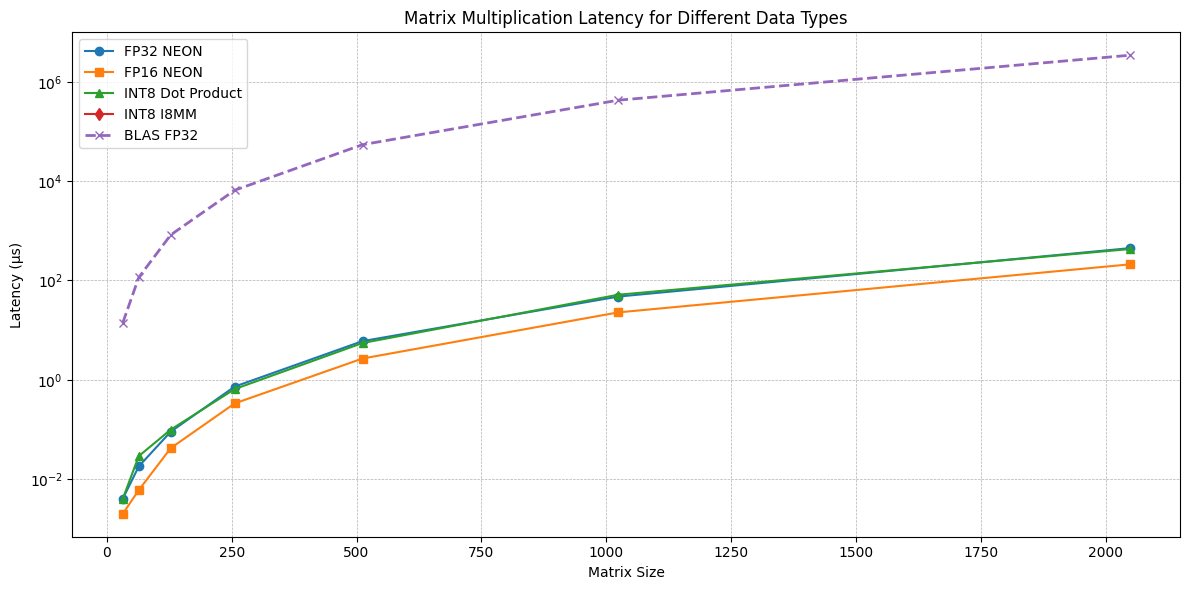

In [5]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 

# Load datasets
f32_data = pd.read_csv("src/cpp/results/f32_scaling_results.csv")
f16_data = pd.read_csv("src/cpp/results/f16_scaling_results.csv")
int8_dotprod_data = pd.read_csv("src/cpp/results/i8_dotprod_scaling_results.csv")
int8_i8mm_data = pd.read_csv("src/cpp/results/i8_i8mm_scaling_results.csv")
blas_data = pd.read_csv("src/cpp/results/blas_f32_scaling_results.csv")

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot each dataset
plt.plot(f32_data['Size'], f32_data['Latency(us)'], label="FP32 NEON", marker='o')
plt.plot(f16_data['Size'], f16_data['Latency(us)'], label="FP16 NEON", marker='s')
plt.plot(int8_dotprod_data['Size'], int8_dotprod_data['Latency(us)'], label="INT8 Dot Product", marker='^')
plt.plot(int8_i8mm_data['Size'], int8_i8mm_data['Latency(us)'], label="INT8 I8MM", marker='d')
plt.plot(blas_data['Size'], blas_data['Latency(us)'], label="BLAS FP32", marker='x', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel("Matrix Size")
plt.ylabel("Latency (µs)")
plt.title("Matrix Multiplication Latency for Different Data Types")
plt.yscale('log')  # Use log scale for latency if the values span multiple orders of magnitude
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()



# watch the blas fp32 process

Main process ID: 40949


In [21]:
!sudo ./processwatch/processwatch -p 40949-f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              0.00     0.00     0.00     0.00     100.00   25279   
40949    blas_f32_inf     0.00     0.00     0.00     0.00     100.00   25279   

PID      NAME             SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              0.00     0.00     0.00     0.00     100.00   26596   
40949    blas_f32_inf     0.00     0.00     0.00     0.00     100.00   26596   
^C


In [22]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

# watch the kleidiai FP32 process 

Main process ID: 40979



PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              70.70    0.00     0.00     0.00     0.00     100.00   25241   
40979    kai_f32_inf      70.70    0.00     0.00     0.00     0.00     100.00   25241   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              70.75    0.00     0.00     0.00     0.00     100.00   26571   
40979    kai_f32_inf      70.75    0.00     0.00     0.00     0.00     100.00   26571   
^C


In [25]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

# watch the kleidiai FP16 process 

Main process ID: 41009


In [27]:
!sudo ./processwatch/processwatch -p 41009 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              83.85    0.00     0.00     0.00     0.00     100.00   25200   
41009    kai_f16_inf      83.85    0.00     0.00     0.00     0.00     100.00   25200   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              83.90    0.00     0.00     0.00     0.00     100.00   26517   
41009    kai_f16_inf      83.90    0.00     0.00     0.00     0.00     100.00   26517   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              83.93    0.00     0.00     0.00     0.00     100.00   25219   
41009    kai_f16_inf      83.93    0.00     0.00     0.00     0.00     100.00   25219   
^C


# watch the kleidiai INT8/4 DotProd process 

Main process ID: 41077


In [31]:
!sudo ./processwatch/processwatch -p 41077 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              57.83    0.00     0.00     0.00     5.37     100.00   25290   
41077    kai_i8_dotprod_  57.83    0.00     0.00     0.00     5.37     100.00   25290   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              57.65    0.00     0.00     0.00     5.49     100.00   26615   
41077    kai_i8_dotprod_  57.65    0.00     0.00     0.00     5.49     100.00   26615   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              58.20    0.00     0.00     0.00     5.44     100.00   25301   
41077    kai_i8_dotprod_  58.20    0.00     0.00     0.00     5.44     100.00   25301   
^C


In [32]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

# watch the kleidiai int8/4 i8mm process

In [33]:
import subprocess
import os
import time
import signal

# Run the main process
process = subprocess.Popen(
    ["src/cpp/f32_i8_i4_i8mm/build/kai_i8_i8mm_inf"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Main process ID: {process.pid}")

Main process ID: 41106


In [34]:
!sudo ./processwatch/processwatch -p 41106 -f HasNEON -f HasSVE -f HasSVE2 -f HasMatMulInt8 -f HasDotProd 


PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              42.02    0.00     0.00     6.16     0.00     100.00   25293   
41106    kai_i8_i8mm_inf  42.02    0.00     0.00     6.16     0.00     100.00   25293   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              41.26    0.00     0.00     6.55     0.00     100.00   26598   
41106    kai_i8_i8mm_inf  41.26    0.00     0.00     6.55     0.00     100.00   26598   

PID      NAME             NEON     SVE      SVE2     MatMulIn DotProd  %TOTAL   TOTAL   
ALL      ALL              41.44    0.00     0.00     6.57     0.00     100.00   25285   
41106    kai_i8_i8mm_inf  41.44    0.00     0.00     6.57     0.00     100.00   25285   
^C


In [35]:
import os
import signal

os.kill(process.pid, signal.SIGTERM)

# Onto KLEIDIAI Integrations with torch. Lets start by using the 4bit weight only kernel

In [36]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torchao.quantization.utils import prepare_int4_weight_and_scales_and_zeros
from torchao.utils import find_multiple

### Set some matmul hyperparameters 

In [37]:
out_features = 256 
in_features = 128
groupsize = 32 
inner_k_tiles = 8

### Create the floating point matrices 

In [38]:
weight = torch.randn(out_features, in_features, dtype=torch.float32)
x = torch.randn(1, in_features, dtype=torch.float32)

## use torchao to perform the group quantization 

In [39]:
w_int4x8, scales_and_zeros = prepare_int4_weight_and_scales_and_zeros(
    weight, 
    groupsize, 
    inner_k_tiles, 
    "symmetric_groupwise", 
    precision=torch.float32,
)

### Look at the shapes to see what has been done 

In [40]:
print(f"Full Precision weights: shape {weight.shape} dtype {weight.dtype}")
print(f"Prepared weights: shape {w_int4x8.shape} dtype {w_int4x8.dtype}")
print(" ")
print("weight number equality: ", w_int4x8.numel(), "==", weight.numel()//2 + (weight.numel()//groupsize * 2))

Full Precision weights: shape torch.Size([256, 128]) dtype torch.float32
Prepared weights: shape torch.Size([1024, 18]) dtype torch.uint8
 
weight number equality:  18432 == 18432


**Explanation of the Prepared Weights Size**

We can see above that the following equality between the number of weights in the prepared quantized weights (w-int4x8) and the original weights (weight) is true. 

```python
w_int4x8.numel() == (weight.numel() // 2) + (weight.numel() // groupsize * 2) 
```

***NOTE: weight.numel() gives the number of elements inside a pytorch tensor***

This can be explained by our use of 4-bit quantization in which we need to pack the quantized weights in addition to it's scale parameters into the w_int4x8 tensor. To do so, this can be interpreted in two parts:

1. **Half the number of weights**:  
   - Because each original weight is mapped to a 4-bit number, and two 4-bit values fit in a single byte, we only need half as many bytes as the total number of full-precision weights.  
   - This is expressed by `(weight.numel() // 2)` in the weight number equality.

2. **Storage for scale parameters**:  
   - Each group of weights has a corresponding scale factor, and the number of groups is `(weight.numel() // groupsize)`.  
   - These scale factors are stored in `float16` format, which requires 2 bytes for each scale, leading to `* 2`.  
   - Hence, the term `(weight.numel() // groupsize * 2)` accounts for the total bytes needed for all scale factors.

Therefore, when you add these two parts:

```python
(weight.numel() // 2) + (weight.numel() // groupsize * 2) 
```

you get the total storage (in bytes) for the quantized weights plus the scale parameters. This total matches the number of elements in `w_int4x8`, ensuring the shape `torch.Size([1024, 18])` correctly reflects both packed 4-bit weights and their scale factors.


**Explanation of the Prepared Weights shape**

In [41]:
w_int4x8.shape

torch.Size([1024, 18])

The weight preparation function has performed group quantization, quantizing each group to a single row in the matrix. This gives `weight.numel()s//group_size` rows. We can check that it is true using the below line 

In [42]:
weight.numel() // groupsize

1024

ok so that means that there is one group per row, each one with their own scale parameter. Given that the groupsize we have used is 32, and when using 4-bit quantization we can pack 2 elemtns into a single byte, that gives a row size of 16 bytes. This leaves a discrepancy of 2 bytes. This 2 byte difference is used to hold the symmetric scale parameter in float16 format. Therefore the row size of w_int4x8 is: 

In [43]:
groupsize // 2 + 2

18

# Lets now use the kleidiai kernel that has been integrated into torch 
after performing the quantization, we must pack the weight into a shape required by the kleidiai kernels. This, is a memory optimization step. 

In [44]:
weight_int4pack = torch.ops.aten._kai_weight_pack_int4(w_int4x8, scales_and_zeros.float(), out_features, in_features, groupsize)

# define a forward function to use the kleidi kernel 

In [45]:
def linear_forward_int4_symmetric_groupwise(x, weight_int4pack, out_features, in_features):
    origin_x_size = x.size()
    c = torch.ops.aten._kai_input_quant_mm_int4(x, weight_int4pack, x.shape[-2],out_features, in_features, 32)
    new_shape = origin_x_size[:-1] + (out_features,)
    c = c.reshape(new_shape)
    return c


In [46]:
out_kai = linear_forward_int4_symmetric_groupwise(x, weight_int4pack, out_features, in_features)

# lets check the quantization error compared to the fp32 multiplication 

In [47]:
out_baseline = torch.matmul(x, weight.T) # compute the baseline operation
print(out_kai.flatten()[:5])
print(out_baseline.flatten()[:5])
error = (out_baseline - out_kai).abs() / out_baseline.abs()

tensor([10.7431, -0.0724, -6.2523,  3.7692, -3.8037])
tensor([10.5821, -0.0892, -7.1642,  3.7358, -4.9737])


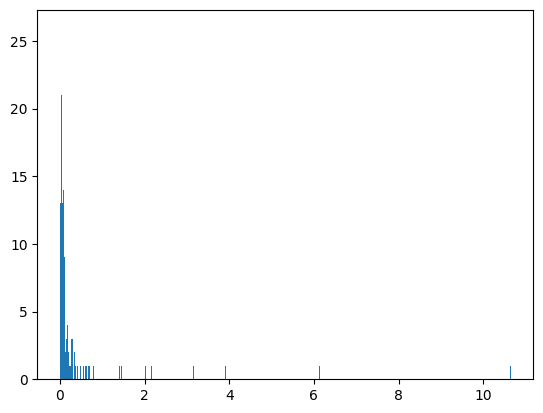

In [48]:
import matplotlib.pyplot as plt 
plt.hist(error.flatten().numpy(), bins=1000)
plt.show()

## Quantizing A model with KleidiAI
define a 4-bit weight only linear using kleidiai kernel

In [67]:
class Int4WeightOnlyKAILinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True): 
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.register_buffer(
            "weight",
            torch.zeros((torch.ops.aten.get_kai_weight_pack_int4_size(out_features,in_features,groupsize)), dtype=torch.uint8)
        )

        self.register_buffer(
            "scales_and_zeros",
            torch.zeros((0), dtype=torch.float32)
        )

        if bias is not False: 
            self.register_buffer(
                "bias",
                torch.zeros((self.out_features), dtype=torch.float32)
            )
        else: 
            self.register_buffer("bias", None)

    def forward(self, x):
        out = linear_forward_int4_symmetric_groupwise(x, self.weight, self.out_features, self.in_features)
        if self.bias is not None:
            out += self.bias 
        return out

define function to return quantized version of layer

In [68]:
def quantize_linear_layer(layer):
    fp_weight = layer.weight.data.detach()
    out_features = layer.out_features
    in_features = layer.in_features

    w_int4x8, scales_and_zeros = prepare_int4_weight_and_scales_and_zeros(
        fp_weight, 
        groupsize=32, # groupsize
        inner_k_tiles=8, # inner_k_tiles 
        scheme="symmetric_groupwise", 
        precision=torch.float32
    )

    weight_int4pack = torch.ops.aten._kai_weight_pack_int4(
        w_int4x8, 
        scales_and_zeros.float(), 
        out_features, 
        in_features, 
        groupsize
    )

    use_bias = layer.bias is not None
    layer4bit = Int4WeightOnlyKAILinear(in_features, out_features, use_bias)

    layer4bit.weight = weight_int4pack
    layer4bit.scales_and_zeros = scales_and_zeros
    if use_bias:
        layer4bit.bias.data.copy_(layer.bias.data)

    return layer4bit


define function to quantize an entire nn.Module inplace

In [69]:
def quantize_model(model):
    for name, child in model.named_children():
        if isinstance(child, nn.Linear):
            # Quantize the linear layer
            quantized_layer = quantize_linear_layer(child)
            setattr(model, name, quantized_layer)
        else:
            # Recursively apply to child modules
            quantize_model(child)
    return model


create the model

In [70]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer


model = AutoModelForCausalLM.from_pretrained("apple/OpenELM-270M-Instruct", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", trust_remote_code=True)

prompt = "Arm is a company that" 
inputs = tokenizer(prompt, return_tensors="pt")

Lets sample a generation from the model

In [71]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

generated_ids = model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, max_length=20)
generated_text_fp = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
generated_text_fp

'Arm is a company that has been in the business of manufacturing and supplying various types of'

before quantizing get full precision memory consumption

In [72]:
import torch

baseline_memory_consumption = 0  # Memory in bytes
for name, param in model.named_parameters():  # Use model.named_parameters() to iterate over model parameters
    baseline_memory_consumption += param.numel() * param.element_size()

# Convert to megabytes (MB)
baseline_memory_consumption_mb = baseline_memory_consumption / (1024 ** 2)

print(f"Baseline memory consumption: {baseline_memory_consumption_mb:.2f} MB")

Baseline memory consumption: 1035.79 MB


before quantizing get the full precision generation latency 

In [73]:
import time
    
baseline_latency = 0
for _ in range(10):
    st = time.time()
    model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, max_length=20)
    et = time.time()
    baseline_latency += (et - st) * 1000
baseline_latency /= 10

print(f"Time taken: {baseline_latency:.2f} ms")

Time taken: 434.65 ms


qauntize the model 

In [74]:
quantize_model(model.transformer)

OpenELMModel(
  (token_embeddings): Embedding(32000, 1280)
  (layers): ModuleList(
    (0-4): 5 x OpenELMDecoderLayer(
      (attn): OpenELMMultiHeadCausalAttention(
        query_heads=12, key_heads=3, value_heads=3
        (qkv_proj): Int4WeightOnlyKAILinear()
        (pos_embedding): OpenELMRotaryEmbedding(	model_dim=64, max_seq_length=4096, freq_constant=10000)
        (q_norm): OpenELMRMSNorm(num_features=64, eps=1e-06)
        (k_norm): OpenELMRMSNorm(num_features=64, eps=1e-06)
        (out_proj): Int4WeightOnlyKAILinear()
      )
      (ffn): OpenELMFeedForwardNetwork(
        (ffn_with_glu) : True
        (proj_1): Int4WeightOnlyKAILinear()
        (proj_2): Int4WeightOnlyKAILinear()
        (act): SiLU()
      )
      (ffn_norm): OpenELMRMSNorm(num_features=1280, eps=1e-06)
      (attn_norm): OpenELMRMSNorm(num_features=1280, eps=1e-06)
    )
    (5-11): 7 x OpenELMDecoderLayer(
      (attn): OpenELMMultiHeadCausalAttention(
        query_heads=16, key_heads=4, value_heads=4


Get the quantized memory consumption

In [75]:
import torch

quantized_memory_consumption = 0  # Memory in bytes
for name, param in model.named_parameters():  # Use model.named_parameters() to iterate over model parameters
    quantized_memory_consumption += param.numel() * param.element_size()

# Convert to megabytes (MB)
quantized_memory_consumption_mb = quantized_memory_consumption / (1024 ** 2)

print(f"Baseline memory consumption: {quantized_memory_consumption_mb:.2f} MB")

Baseline memory consumption: 156.42 MB


Get the quantized latency

In [76]:
import time

quantized_latency = 0
for _ in range(10):
    st = time.time()
    model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, max_length=20)
    et = time.time()
    quantized_latency += (et - st) * 1000
quantized_latency /= 10

print(f"Time taken: {quantized_latency:.2f} ms")

Time taken: 306.34 ms


generate from the quantized model 

In [77]:
generated_ids = model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"], pad_token_id=tokenizer.pad_token_id, max_length=20)
generated_text_4bit = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
generated_text_4bit

'Arm is a company that specializes in the design, manufacture, and installation of custom-'